In [187]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv


To evaluate model performance on the dataset, I followed these steps:

**Exploratory Data Analysis (EDA):**
I started by exploring the dataset to understand the structure, data types, and distribution of features.

**Initial Model Testing:**
I manually built a few models with randomly selected layer configurations and trained them to get a baseline idea of how the model performs.

**Hyperparameter Tuning with Keras Tuner:**
I used the Keras Tuner library to systematically search for the best combination of hyperparameters, including number of layers, number of units per layer, dropout rates, and learning rate.

**Final Model Training:**
Using the best hyperparameters obtained from tuning, I trained a final model to predict with improved accuracy.

# **Step 1: Exploratory Data Analysis (EDA)** 
I started by exploring the dataset to understand the structure, data types, and distribution of features.

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df=pd.read_csv('/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv')
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

In [189]:
rename_dict = {
    'age': 'age_years',
    'sex': 'gender',  # 1 = male; 0 = female
    'cp': 'chest_pain_type',  # 0-3
    'trestbps': 'resting_bp_mmHg',
    'chol': 'serum_cholesterol_mg_dl',
    'fbs': 'fasting_blood_sugar_gt_120',  # 1 = true; 0 = false
    'restecg': 'resting_ecg_result',  # 0-2
    'thalach': 'max_heart_rate_achieved',
    'exang': 'exercise_induced_angina',  # 1 = yes; 0 = no
    'oldpeak': 'st_depression_exercise',
    'slope': 'st_slope',  # 0-2
    'ca': 'num_major_vessels_flouroscopy',
    'thal': 'thal_defect_type',  # 0 = normal, 1 = fixed, 2 = reversible
    'condition': 'has_heart_disease'  # 0 = no disease, 1 = disease
}
df=df.rename(columns=rename_dict)
df.columns

Index(['age_years', 'gender', 'chest_pain_type', 'resting_bp_mmHg',
       'serum_cholesterol_mg_dl', 'fasting_blood_sugar_gt_120',
       'resting_ecg_result', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression_exercise', 'st_slope',
       'num_major_vessels_flouroscopy', 'thal_defect_type',
       'has_heart_disease'],
      dtype='object')

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_years                      297 non-null    int64  
 1   gender                         297 non-null    int64  
 2   chest_pain_type                297 non-null    int64  
 3   resting_bp_mmHg                297 non-null    int64  
 4   serum_cholesterol_mg_dl        297 non-null    int64  
 5   fasting_blood_sugar_gt_120     297 non-null    int64  
 6   resting_ecg_result             297 non-null    int64  
 7   max_heart_rate_achieved        297 non-null    int64  
 8   exercise_induced_angina        297 non-null    int64  
 9   st_depression_exercise         297 non-null    float64
 10  st_slope                       297 non-null    int64  
 11  num_major_vessels_flouroscopy  297 non-null    int64  
 12  thal_defect_type               297 non-null    int

In [191]:
print(f"gender: {list(df['gender'].unique())}")
print(f"chest_pain_type: {list(df['chest_pain_type'].unique())}")
print(f"fasting_blood_sugar_gt_120: {list(df['fasting_blood_sugar_gt_120'].unique())}")
print(f"resting_ecg_result: {list(df['resting_ecg_result'].unique())}")
print(f"exercise_induced_angina: {list(df['exercise_induced_angina'].unique())}")
print(f"thal_defect_type: {list(df['thal_defect_type'].unique())}")
print(f"has_heart_disease: {list(df['has_heart_disease'].unique())}")

gender: [1, 0]
chest_pain_type: [0, 1, 2, 3]
fasting_blood_sugar_gt_120: [1, 0]
resting_ecg_result: [2, 0, 1]
exercise_induced_angina: [0, 1]
thal_defect_type: [0, 2, 1]
has_heart_disease: [0, 1]


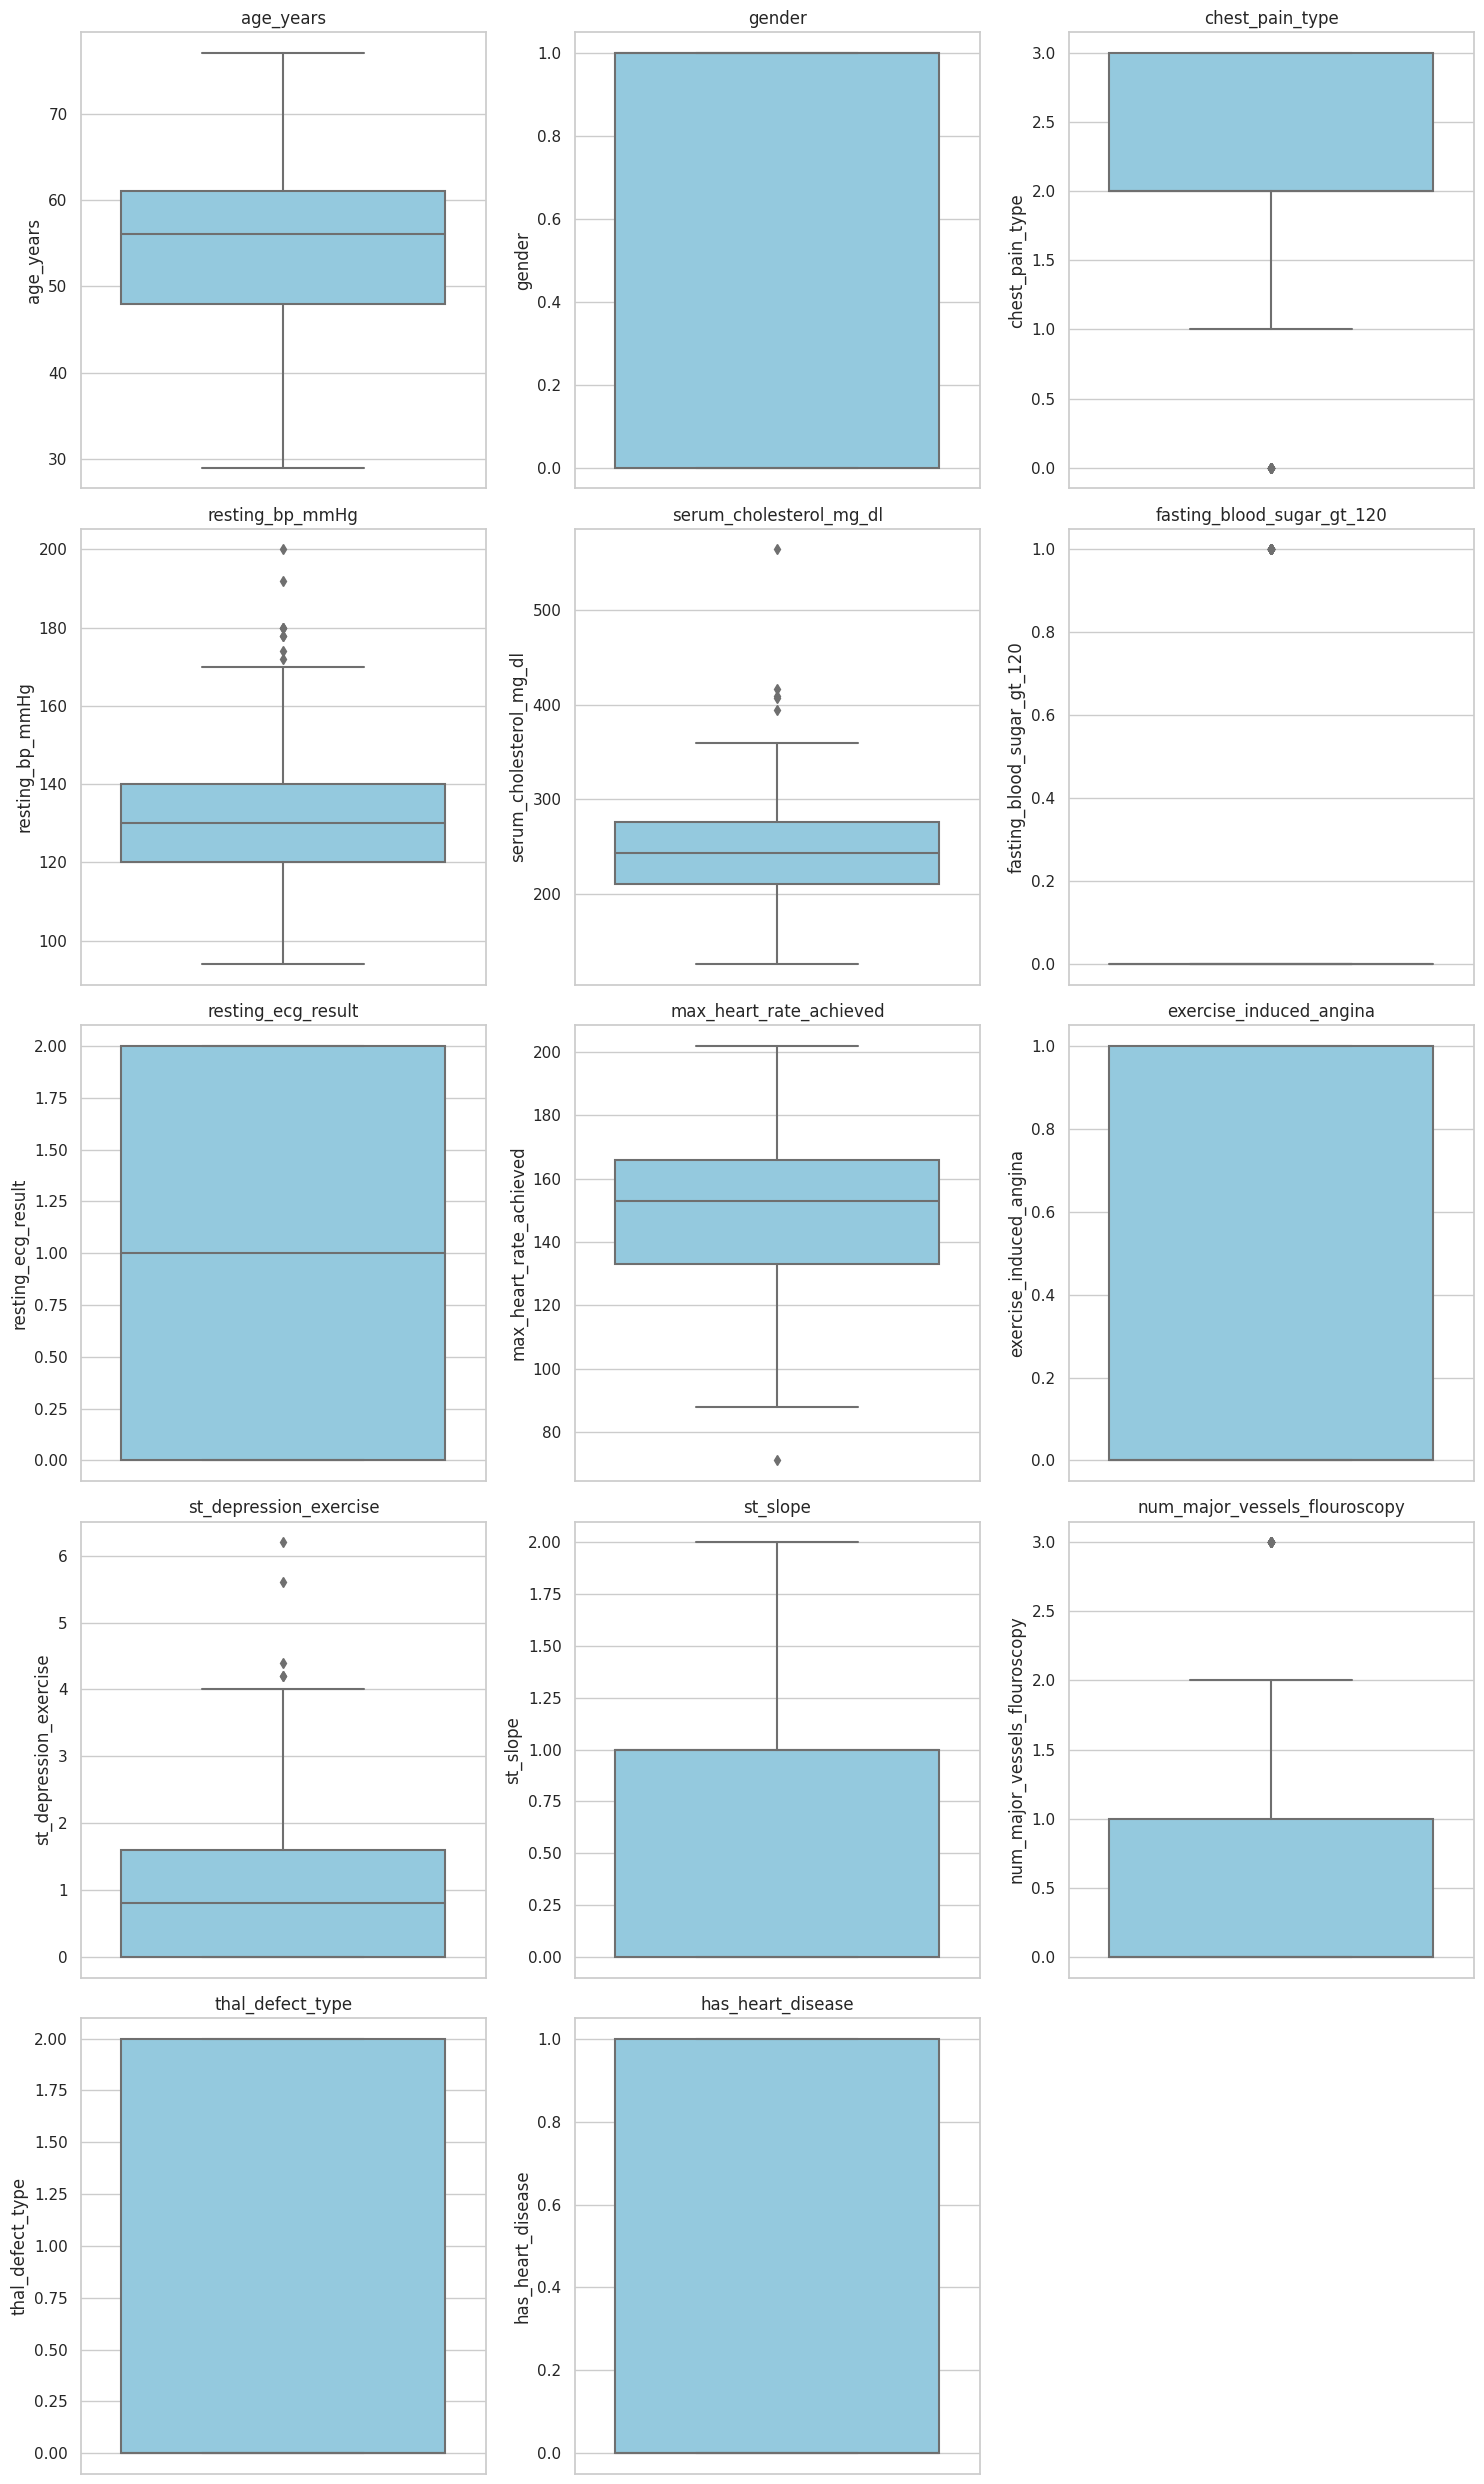

In [192]:

sns.set(style="whitegrid")
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
cols_per_row = 3
total_cols = len(numeric_columns)
rows = (total_cols + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 5 * rows))
axes = axes.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# **Step 2: Initial Model Testing**
I manually built a few models with randomly selected layer configurations and trained them to get a baseline idea of how the model performs.

In [193]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1]  # all columns except last
y = df.iloc[:, -1:]  # last column
print(X.columns)
print(y.columns)

Index(['age_years', 'gender', 'chest_pain_type', 'resting_bp_mmHg',
       'serum_cholesterol_mg_dl', 'fasting_blood_sugar_gt_120',
       'resting_ecg_result', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression_exercise', 'st_slope',
       'num_major_vessels_flouroscopy', 'thal_defect_type'],
      dtype='object')
Index(['has_heart_disease'], dtype='object')


In [194]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [195]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout

In [196]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.transform(y_test)

In [197]:
model = Sequential()

# Input layer + 1st hidden layer
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
# 2nd hidden layer
model.add(Dense(16, activation='relu'))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [198]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy()])


In [199]:
# history = model.fit(
#     X_train_scaled,
#     y_train,
#     epochs=30,
#     validation_split=0.1,
#     verbose=1
# )
early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True,mode='max')

history=model.fit(X_train, y_train, validation_data=(X_test_scaled, y_test), epochs=30, callbacks=[early_stop])


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - binary_accuracy: 0.4601 - loss: 53.6930 - val_binary_accuracy: 0.4667 - val_loss: 0.7805
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.4373 - loss: 40.2897 - val_binary_accuracy: 0.4667 - val_loss: 0.7535
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.5121 - loss: 26.2643 - val_binary_accuracy: 0.4667 - val_loss: 0.7300
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.4546 - loss: 24.9294 - val_binary_accuracy: 0.4667 - val_loss: 0.7107
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.4082 - loss: 18.6835 - val_binary_accuracy: 0.5167 - val_loss: 0.6960
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.4878 - loss: 11.4906 - val_binary_accuracy: 0.5333 - val_loss: 0.6867
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.4646 - loss: 10.0730 - val_binary_accuracy: 0.5167 - val_loss: 0.6803
Epoch 8/30
8/8 ━━━━━

In [200]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.5979 - loss: 0.6576

Test Accuracy: 0.6000


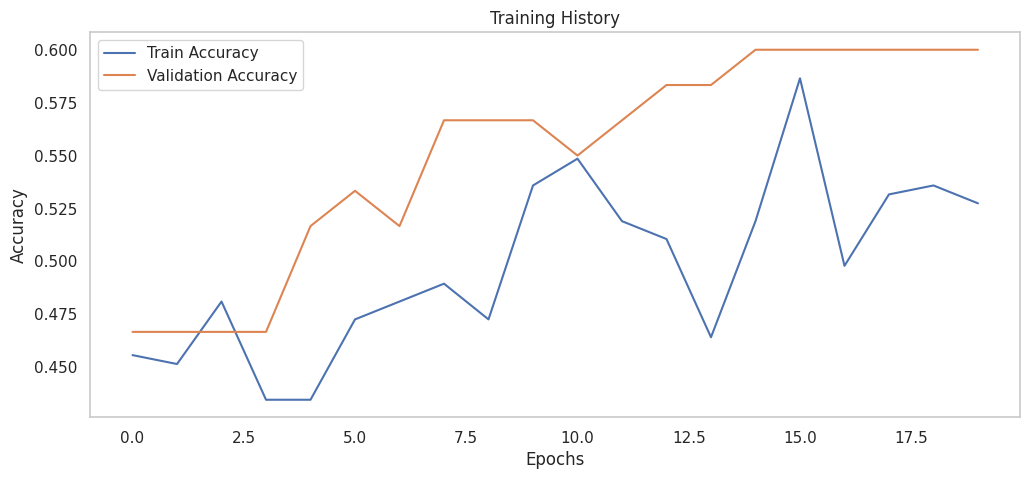

In [201]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.grid(False)
plt.show()

In [202]:
print("Class distribution:\n", y_train.value_counts())


Class distribution:
 has_heart_disease
0                    128
1                    109
Name: count, dtype: int64


# **Step 3: Hyperparameter Tuning with Keras Tuner**
I used the Keras Tuner library to systematically search for the best combination of hyperparameters, including number of layers, number of units per layer, dropout rates, and learning rate.

In [203]:

import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('input_units', min_value=8, max_value=128, step=8),
                    activation='relu', input_shape=(X_train.shape[1],)))
    
    # Tune the number of hidden layers and their units
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 2 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=8, max_value=128, step=8),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model


In [204]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_binary_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='heart_disease_tuning'
)

Reloading Tuner from kt_dir/heart_disease_tuning/tuner0.json


In [205]:
import keras
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test_scaled, y_test),
             callbacks=[keras.callbacks.EarlyStopping(patience=3)],verbose=1 )

In [206]:
best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]


best_hyperparameters=dict()
print("Best hyperparameters:")
for param in best_hps.values:
    best_hyperparameters[param]=best_hps.get(param)
    print(f"{param}: {best_hps.get(param)}")

Best hyperparameters:
input_units: 16
num_layers: 1
units_0: 96
dropout_0: 0.2
learning_rate: 0.009289736980750272
units_1: 96
dropout_1: 0.4
units_2: 24
dropout_2: 0.30000000000000004


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [207]:
best_hyperparameters

{'input_units': 16,
 'num_layers': 1,
 'units_0': 96,
 'dropout_0': 0.2,
 'learning_rate': 0.009289736980750272,
 'units_1': 96,
 'dropout_1': 0.4,
 'units_2': 24,
 'dropout_2': 0.30000000000000004}

# **Step 4: Final Model Training**
Using the best hyperparameters obtained from tuning, I trained a final model to predict with improved accuracy.

In [208]:
# Model
model_wt_hps = Sequential()
model_wt_hps.add(Dense(best_hyperparameters['units_0'], activation='relu', input_shape=(13,)))
model_wt_hps.add(Dropout(best_hyperparameters['dropout_0']))

# If more layers were selected
if best_hyperparameters['num_layers'] > 1:
    model_wt_hps.add(Dense(best_hyperparameters['units_1'], activation='relu'))
    model_wt_hps.add(Dropout(best_hyperparameters['dropout_1']))
if best_hyperparameters['num_layers'] > 2:
    model_wt_hps.add(Dense(best_hyperparameters['units_2'], activation='relu'))
    model_wt_hps.add(Dropout(best_hyperparameters['dropout_2']))

model_wt_hps.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'])
model_wt_hps.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

history = model_wt_hps.fit(
    X_train_scaled, y_train,
    epochs=20,
    validation_data=(X_test_scaled, y_test),
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - binary_accuracy: 0.7645 - loss: 0.5461 - val_binary_accuracy: 0.7500 - val_loss: 0.4806
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8641 - loss: 0.3369 - val_binary_accuracy: 0.7167 - val_loss: 0.5642
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.8349 - loss: 0.3407 - val_binary_accuracy: 0.7167 - val_loss: 0.5895
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.8702 - loss: 0.2766 - val_binary_accuracy: 0.7333 - val_loss: 0.6262


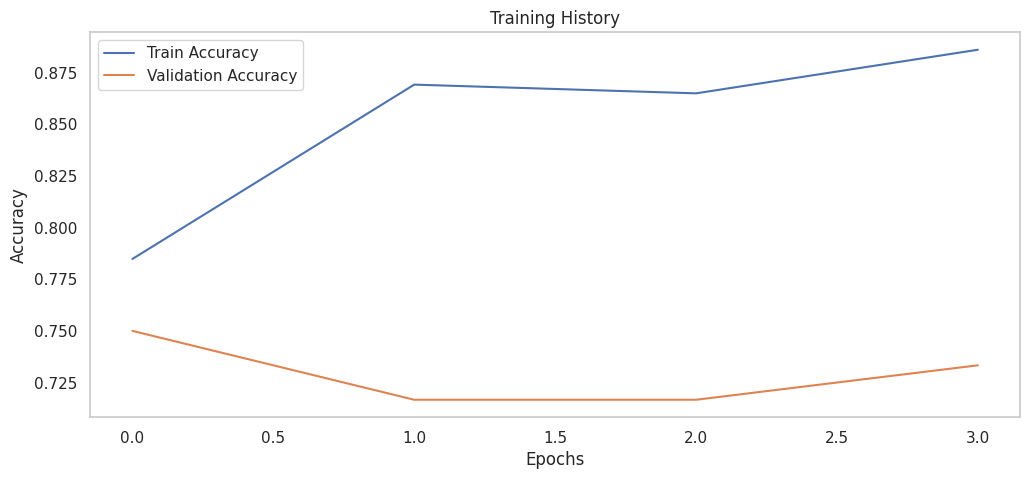

In [209]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.grid(False)
plt.show()